# Artificial Intelligence Assignment 1
Genetic Algorithm for the Travelling Salesman Problem.

# Step 1: Loading the data

First we need to manipulate the data set text file provided into our three travelling salesman problems. We can then extract the cities from these new variables (strings)

In [38]:
# load the data sets tsp text file

def prepare_tsp_files(dataset: str):
    with open(dataset, 'r') as file:
        lines = file.readlines()
        coords = {}
        node_section = False
        for line in lines:
            if line.startswith("NODE_COORD_SECTION"):
                node_section = True
                continue
            if line.strip() == "EOF":
                break
            if node_section:
                parts = line.strip().split()
                node_id = int(parts[0])
                x, y = float(parts[1]), float(parts[2])
                coords[node_id] = (x, y)  
    return coords

# Step 2: Computing Distance Matrix

Here we'll write a function that computes a distance matrix which will make it easier to provide a solution for each TSP.

In [39]:
from scipy.spatial.distance import euclidean
import numpy as np

def compute_distance_matrix(coords):
    """ Computes a distance matrix for TSP. """
    n = len(coords)
    distance_matrix = np.zeros((n, n))

    for i in range(n):
        for j in range(n):
            if i != j:
                distance_matrix[i][j] = euclidean(coords[i+1], coords[j+1])  

    return distance_matrix


In [40]:
import random 

# fitness function
def calculate_fitness(route, distance_matrix):
    fitness = 0
    for i in range(len(route) - 1):
        fitness += distance_matrix[route[i]][route[i+1]]
    fitness += distance_matrix[route[-1]][route[0]] # going back to the starting city
    return fitness

In [41]:
# tournament selection

def tournament_selection(population, fitness_values, tournament_size):
    selected = random.sample(list(enumerate(fitness_values)), tournament_size)
    best = min(selected, key=lambda x: x[1])
    return population[best[0]]

In [42]:
# crossover 1: ordered crossover (OX1)

def ordered_crossover(parent1, parent2):
    size = len(parent1)
    start, end = sorted(random.sample(range(size), 2))

    child = [-1] * size
    child[start:end] = parent1[start:end]

    remaining = [item for item in parent2 if item not in child]
    index = 0
    for i in range(size):
        if child[i] == -1:
            child[i] = remaining[index]
            index += 1
    return child

# crossover 2: partially mapped crossover (PMX)
def pmx_crossover(parent1, parent2):
    size = len(parent1)
    start, end = sorted(random.sample(range(size), 2))

    child = [-1] * size
    child[start:end] = parent1[start:end]

    mapping = {parent1[i]: parent2[i] for i in range(start, end)}

    for i in range(size):
        if i < start or i >= end:
            value = parent2[i]
            while value in mapping:
                value = mapping[value]
            child[i] = value

    return child


In [43]:
# mutation 1: swap mutation

def swap_mutation(route, mutation_rate):
    if random.random() < mutation_rate:
        idx1, idx2 = random.sample(range(len(route)), 2)
        route[idx1], route[idx2] = route[idx2], route[idx1]
    return route

# mutation 2: scramble mutation

def scramble_mutation(route, mutation_rate):
    if random.random() < mutation_rate:
        start, end = sorted(random.sample(range(len(route)), 2))
        subset = route[start:end]
        random.shuffle(subset)
        route[start:end] = subset
    return route


In [44]:
def genetic_algorithm(distance_matrix, population_size=100, generations=500, mutation_rate=0.1, crossover=ordered_crossover, mutation=swap_mutation):
    population = [random.sample(range(len(distance_matrix)), len(distance_matrix)) for _ in range(population_size)]
    avg_distances = []  # Stores avg fitness per generation

    for gen in range(generations):
        fitness_values = [calculate_fitness(ind, distance_matrix) for ind in population]
        avg_distance = sum(fitness_values) / len(fitness_values)  # Compute average fitness in the generation
        avg_distances.append(avg_distance)

        parents = [tournament_selection(population, fitness_values, 3) for _ in range(population_size)]
        offspring = []

        for i in range(0, population_size, 2):
            child1 = crossover(parents[i], parents[i+1])
            child2 = crossover(parents[i+1], parents[i])
            offspring.append(mutation(child1, mutation_rate))
            offspring.append(mutation(child2, mutation_rate))

        population = offspring

    best_index = fitness_values.index(min(fitness_values))  # Find the index of the best individual
    best_route = population[best_index]  # Retrieve the best route

    best_distance = min(fitness_values)
    worst_distance = max(fitness_values)

    return best_distance, worst_distance, avg_distances, best_route  # ✅ Now returning four values


# Berlin52 - Grid Search

As Berlin52 is the smallest dataset, it's feasible to try grid search to determine the best population size. 

Grid Search Progress: 100%|██████████| 108/108 [07:15<00:00,  4.03s/config]


=== Grid Search Results (Sorted by Best Fitness) ===

            Crossover           Mutation  Population Size  Generations  \
26  ordered_crossover      swap_mutation              500          500   
25  ordered_crossover      swap_mutation              500          500   
21  ordered_crossover      swap_mutation              500          200   
80      pmx_crossover      swap_mutation              500          500   
51  ordered_crossover  scramble_mutation              500          500   
..                ...                ...              ...          ...   
57      pmx_crossover      swap_mutation              100          200   
56      pmx_crossover      swap_mutation              100          100   
84      pmx_crossover  scramble_mutation              100          200   
83      pmx_crossover  scramble_mutation              100          100   
81      pmx_crossover  scramble_mutation              100          100   

    Mutation Rate  Best Fitness (Best Distance)  Final F

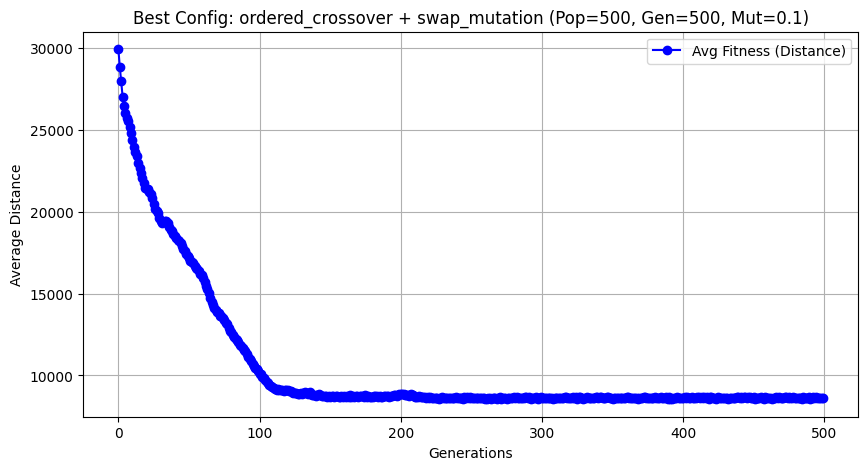


=== Best Route Found ===
[10, 51, 13, 12, 26, 46, 25, 27, 11, 24, 4, 23, 47, 36, 38, 35, 34, 33, 43, 45, 15, 28, 49, 19, 22, 29, 20, 41, 1, 6, 16, 17, 30, 21, 0, 31, 48, 39, 37, 14, 5, 3, 42, 44, 2, 18, 40, 7, 8, 9, 32, 50]


In [45]:
import time
import itertools
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm  # ✅ Progress bar for tracking progress

# Define parameter grid
crossover_methods = [ordered_crossover, pmx_crossover]
mutation_methods = [swap_mutation, scramble_mutation]
population_sizes = [100, 200, 500]
num_generations = [100, 200, 500]
mutation_rates = [0.01, 0.05, 0.1]

# Prepare the TSP dataset
city_coords = prepare_tsp_files('berlin52.txt')
distance_matrix = compute_distance_matrix(city_coords)

# Function to run GA for a given configuration
def run_ga(crossover, mutation, pop_size, generations, mutation_rate):
    start_time = time.time()
    best_distance, worst_distance, avg_distances, best_route = genetic_algorithm(
        distance_matrix, population_size=pop_size, generations=generations,
        mutation_rate=mutation_rate, crossover=crossover, mutation=mutation)
    end_time = time.time()
    
    execution_time = end_time - start_time
    final_distance = avg_distances[-1]  # Last recorded average fitness

    # Store results in a structured format
    return {
        "Crossover": crossover.__name__,
        "Mutation": mutation.__name__,
        "Population Size": pop_size,
        "Generations": generations,
        "Mutation Rate": mutation_rate,
        "Best Route": best_route,  # ✅ Now storing the best route
        "Best Fitness (Best Distance)": round(best_distance, 2),
        "Final Fitness (Last Gen Avg)": round(final_distance, 2),
        "Execution Time (s)": round(execution_time, 2),
        "Avg Distances": avg_distances  # ✅ Store fitness progress for plotting
    }

# Run grid search sequentially with progress tracking
results = []
configurations = list(itertools.product(crossover_methods, mutation_methods, population_sizes, num_generations, mutation_rates))

# ✅ Use tqdm to show progress
for cfg in tqdm(configurations, desc="Grid Search Progress", unit="config"):
    results.append(run_ga(*cfg))

# Convert results to DataFrame
df_results = pd.DataFrame(results)

# Print best configurations sorted by best fitness
print("\n=== Grid Search Results (Sorted by Best Fitness) ===\n")
df_results_sorted = df_results.sort_values(by=["Best Fitness (Best Distance)"])
print(df_results_sorted[["Crossover", "Mutation", "Population Size", "Generations", "Mutation Rate",
                         "Best Fitness (Best Distance)", "Final Fitness (Last Gen Avg)", "Execution Time (s)"]])

# Save results to CSV (optional)
df_results_sorted.to_csv("berlin_tsp_results.csv", index=False)

# Plot fitness for the best configuration
best_config = df_results_sorted.iloc[0]
plt.figure(figsize=(10, 5))
plt.plot(range(len(best_config["Avg Distances"])), best_config["Avg Distances"], marker='o', linestyle='-', color='b', label="Avg Fitness (Distance)")
plt.xlabel("Generations")
plt.ylabel("Average Distance")
plt.title(f"Best Config: {best_config['Crossover']} + {best_config['Mutation']} (Pop={best_config['Population Size']}, Gen={best_config['Generations']}, Mut={best_config['Mutation Rate']})")
plt.legend()
plt.grid(True)
plt.show()

# Print the best route
print("\n=== Best Route Found ===")
print(best_config["Best Route"])


Grid Search Progress: 100%|██████████| 108/108 [13:14<00:00,  7.35s/config]


=== Grid Search Results (Sorted by Best Fitness) ===

            Crossover           Mutation  Population Size  Generations  \
26  ordered_crossover      swap_mutation              500          500   
25  ordered_crossover      swap_mutation              500          500   
16  ordered_crossover      swap_mutation              200          500   
51  ordered_crossover  scramble_mutation              500          500   
80      pmx_crossover      swap_mutation              500          500   
..                ...                ...              ...          ...   
82      pmx_crossover  scramble_mutation              100          100   
81      pmx_crossover  scramble_mutation              100          100   
46  ordered_crossover  scramble_mutation              500          100   
84      pmx_crossover  scramble_mutation              100          200   
47  ordered_crossover  scramble_mutation              500          100   

    Mutation Rate  Best Fitness (Best Distance)  Final F

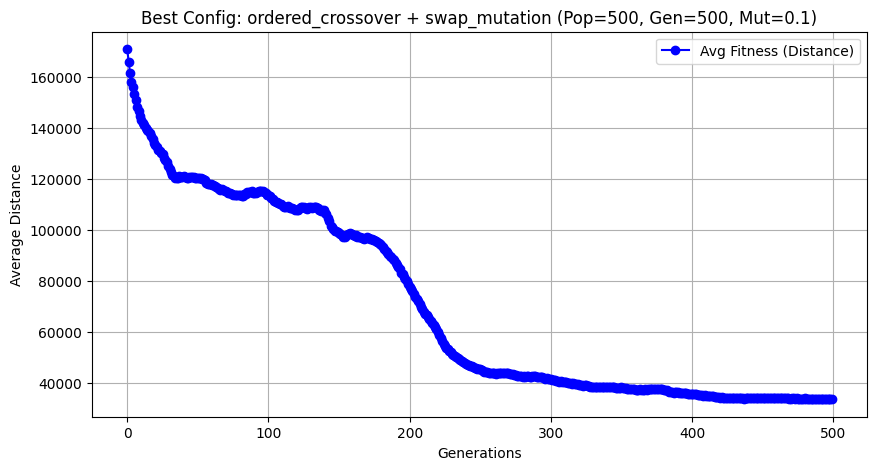


=== Best Route Found ===
[18, 52, 87, 15, 21, 69, 93, 78, 17, 23, 37, 98, 35, 20, 73, 58, 16, 14, 10, 71, 83, 9, 89, 48, 65, 25, 64, 3, 74, 96, 55, 41, 7, 91, 62, 0, 92, 27, 66, 88, 30, 79, 5, 46, 31, 44, 90, 97, 22, 86, 50, 60, 57, 63, 39, 53, 1, 56, 19, 76, 59, 61, 34, 85, 26, 11, 54, 82, 6, 8, 84, 67, 49, 43, 72, 68, 28, 29, 51, 77, 4, 36, 95, 38, 75, 32, 12, 94, 81, 80, 24, 33, 45, 42, 2, 13, 47, 99, 40, 70]


In [46]:
import time
import itertools
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm  # ✅ Progress bar for tracking progress

# Define parameter grid
crossover_methods = [ordered_crossover, pmx_crossover]
mutation_methods = [swap_mutation, scramble_mutation]
population_sizes = [100, 200, 500]
num_generations = [100, 200, 500]
mutation_rates = [0.01, 0.05, 0.1]

# Prepare the TSP dataset
city_coords = prepare_tsp_files('kroA100.txt')
distance_matrix = compute_distance_matrix(city_coords)

# Function to run GA for a given configuration
def run_ga(crossover, mutation, pop_size, generations, mutation_rate):
    start_time = time.time()
    best_distance, worst_distance, avg_distances, best_route = genetic_algorithm(
        distance_matrix, population_size=pop_size, generations=generations,
        mutation_rate=mutation_rate, crossover=crossover, mutation=mutation)
    end_time = time.time()
    
    execution_time = end_time - start_time
    final_distance = avg_distances[-1]  # Last recorded average fitness

    # Store results in a structured format
    return {
        "Crossover": crossover.__name__,
        "Mutation": mutation.__name__,
        "Population Size": pop_size,
        "Generations": generations,
        "Mutation Rate": mutation_rate,
        "Best Route": best_route,  # ✅ Now storing the best route
        "Best Fitness (Best Distance)": round(best_distance, 2),
        "Final Fitness (Last Gen Avg)": round(final_distance, 2),
        "Execution Time (s)": round(execution_time, 2),
        "Avg Distances": avg_distances  # ✅ Store fitness progress for plotting
    }

# Run grid search sequentially with progress tracking
results = []
configurations = list(itertools.product(crossover_methods, mutation_methods, population_sizes, num_generations, mutation_rates))

# ✅ Use tqdm to show progress
for cfg in tqdm(configurations, desc="Grid Search Progress", unit="config"):
    results.append(run_ga(*cfg))

# Convert results to DataFrame
df_results = pd.DataFrame(results)

# Print best configurations sorted by best fitness
print("\n=== Grid Search Results (Sorted by Best Fitness) ===\n")
df_results_sorted = df_results.sort_values(by=["Best Fitness (Best Distance)"])
print(df_results_sorted[["Crossover", "Mutation", "Population Size", "Generations", "Mutation Rate",
                         "Best Fitness (Best Distance)", "Final Fitness (Last Gen Avg)", "Execution Time (s)"]])

# Save results to CSV (optional)
df_results_sorted.to_csv("kroa_tsp_results.csv", index=False)

# Plot fitness for the best configuration
best_config = df_results_sorted.iloc[0]
plt.figure(figsize=(10, 5))
plt.plot(range(len(best_config["Avg Distances"])), best_config["Avg Distances"], marker='o', linestyle='-', color='b', label="Avg Fitness (Distance)")
plt.xlabel("Generations")
plt.ylabel("Average Distance")
plt.title(f"Best Config: {best_config['Crossover']} + {best_config['Mutation']} (Pop={best_config['Population Size']}, Gen={best_config['Generations']}, Mut={best_config['Mutation Rate']})")
plt.legend()
plt.grid(True)
plt.show()

# Print the best route
print("\n=== Best Route Found ===")
print(best_config["Best Route"])


Grid Search Progress: 100%|██████████| 3/3 [1:44:57<00:00, 2099.10s/config]


=== Grid Search Results (Sorted by Best Fitness) ===

           Crossover       Mutation  Population Size  Generations  \
1  ordered_crossover  swap_mutation              500          500   
2  ordered_crossover  swap_mutation              500          500   
0  ordered_crossover  swap_mutation              500          500   

   Mutation Rate  Best Fitness (Best Distance)  Final Fitness (Last Gen Avg)  \
1           0.05                    4908260.77                    5104747.44   
2           0.10                    5025921.85                    5243008.19   
0           0.01                    5117321.61                    5313020.03   

   Execution Time (s)  
1             2096.83  
2             2113.39  
0             2087.08  


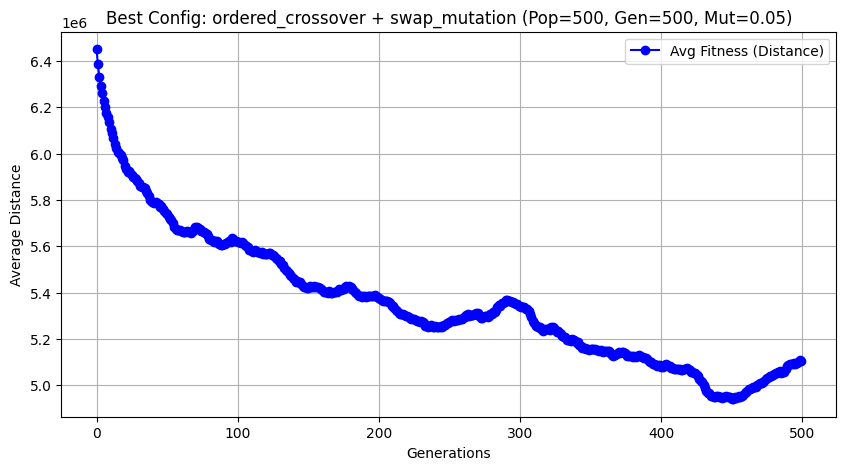


=== Best Route Found ===
[405, 124, 138, 71, 373, 767, 967, 777, 20, 38, 307, 175, 374, 999, 771, 599, 222, 185, 270, 927, 768, 452, 324, 155, 507, 605, 658, 391, 660, 390, 564, 122, 171, 128, 794, 213, 114, 116, 296, 606, 701, 361, 758, 221, 85, 817, 550, 715, 352, 96, 919, 921, 334, 92, 665, 395, 620, 506, 478, 441, 129, 976, 743, 669, 720, 769, 782, 180, 220, 531, 827, 656, 56, 510, 188, 580, 505, 996, 462, 350, 556, 542, 393, 444, 30, 325, 132, 139, 435, 1001, 410, 787, 365, 729, 766, 537, 943, 955, 735, 954, 939, 838, 499, 547, 355, 358, 83, 591, 839, 819, 858, 885, 709, 770, 561, 670, 276, 331, 250, 144, 414, 302, 256, 179, 844, 882, 784, 772, 408, 643, 10, 646, 102, 512, 95, 281, 320, 141, 84, 815, 863, 876, 869, 821, 848, 497, 11, 41, 488, 884, 303, 602, 708, 618, 359, 76, 866, 990, 127, 619, 756, 949, 730, 412, 722, 290, 253, 258, 74, 201, 236, 198, 0, 654, 746, 764, 832, 883, 807, 596, 485, 532, 521, 446, 177, 135, 168, 297, 130, 433, 471, 500, 469, 379, 176, 158, 103, 108, 

In [48]:
import time
import itertools
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm  # ✅ Progress bar for tracking progress

# Define parameter grid
crossover_methods = [ordered_crossover]
mutation_methods = [swap_mutation]
population_sizes = [500]
num_generations = [500]
mutation_rates = [0.01, 0.05, 0.1]

# Prepare the TSP dataset
city_coords = prepare_tsp_files('pr1002.txt')
distance_matrix = compute_distance_matrix(city_coords)

# Function to run GA for a given configuration
def run_ga(crossover, mutation, pop_size, generations, mutation_rate):
    start_time = time.time()
    best_distance, worst_distance, avg_distances, best_route = genetic_algorithm(
        distance_matrix, population_size=pop_size, generations=generations,
        mutation_rate=mutation_rate, crossover=crossover, mutation=mutation)
    end_time = time.time()
    
    execution_time = end_time - start_time
    final_distance = avg_distances[-1]  # Last recorded average fitness

    # Store results in a structured format
    return {
        "Crossover": crossover.__name__,
        "Mutation": mutation.__name__,
        "Population Size": pop_size,
        "Generations": generations,
        "Mutation Rate": mutation_rate,
        "Best Route": best_route,  # ✅ Now storing the best route
        "Best Fitness (Best Distance)": round(best_distance, 2),
        "Final Fitness (Last Gen Avg)": round(final_distance, 2),
        "Execution Time (s)": round(execution_time, 2),
        "Avg Distances": avg_distances  # ✅ Store fitness progress for plotting
    }

# Run grid search sequentially with progress tracking
results = []
configurations = list(itertools.product(crossover_methods, mutation_methods, population_sizes, num_generations, mutation_rates))

# ✅ Use tqdm to show progress
for cfg in tqdm(configurations, desc="Grid Search Progress", unit="config"):
    results.append(run_ga(*cfg))

# Convert results to DataFrame
df_results = pd.DataFrame(results)

# Print best configurations sorted by best fitness
print("\n=== Grid Search Results (Sorted by Best Fitness) ===\n")
df_results_sorted = df_results.sort_values(by=["Best Fitness (Best Distance)"])
print(df_results_sorted[["Crossover", "Mutation", "Population Size", "Generations", "Mutation Rate",
                         "Best Fitness (Best Distance)", "Final Fitness (Last Gen Avg)", "Execution Time (s)"]])

# Save results to CSV (optional)
df_results_sorted.to_csv("pr_tsp_results.csv", index=False)

# Plot fitness for the best configuration
best_config = df_results_sorted.iloc[0]
plt.figure(figsize=(10, 5))
plt.plot(range(len(best_config["Avg Distances"])), best_config["Avg Distances"], marker='o', linestyle='-', color='b', label="Avg Fitness (Distance)")
plt.xlabel("Generations")
plt.ylabel("Average Distance")
plt.title(f"Best Config: {best_config['Crossover']} + {best_config['Mutation']} (Pop={best_config['Population Size']}, Gen={best_config['Generations']}, Mut={best_config['Mutation Rate']})")
plt.legend()
plt.grid(True)
plt.show()

# Print the best route
print("\n=== Best Route Found ===")
print(best_config["Best Route"])
